In [1]:
# Setup
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../python/')
import ENDF6el as el
import flux_recoil_spec as frs
from statistics import median
from pyteomics import mass

os.chdir('../data_files') #Set working directory to shorten paths

In [2]:
#Import Data
f6TR_nu = pd.read_csv('SNOLAB/Fig6TR_neutrons.txt',encoding='utf-16',comment="#",header=None)
f7TR_nu = pd.read_csv('SNOLAB/Fig7TR_neutrons.txt',comment="#",header=None)
f6BR_nu = pd.read_csv('SNOLAB/Fig6BR_neutrons.txt',encoding='utf-16',comment="#",header=None)
f7BR_nu = pd.read_csv('SNOLAB/Fig7BR_neutrons.txt',comment="#",header=None)

# Si Flux and Rate Generation
* CCDs are Si for the sake of flux

In [3]:
#Flux specific to SNOLAB Si Detectors
Er = np.geomspace(100/1e6,1,100) #recoil energy
E,F,ff,ffspec = frs.SNOLAB_flux(Enmin=1e-3)

#Associated rate
drde_Si = (mass.isotopic_composition_abundance({'Si[28]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=28)[0]
        + mass.isotopic_composition_abundance({'Si[29]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=29)[0]
        + mass.isotopic_composition_abundance({'Si[30]':1})*frs.dRdErfast(Er,E,F,N=1,Z=14,A=30)[0]
        )
drde_Ge = (mass.isotopic_composition_abundance({'Ge[70]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=70)[0]
        + mass.isotopic_composition_abundance({'Ge[72]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=72)[0]
        + mass.isotopic_composition_abundance({'Ge[73]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=73)[0]
        + mass.isotopic_composition_abundance({'Ge[74]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=74)[0]
        + mass.isotopic_composition_abundance({'Ge[76]':1})*frs.dRdErfast(Er,E,F,N=1,Z=32,A=76)[0]
        )

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017017094, intercept=-12.883178144228603, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.014824519476613082, intercept_stderr=0.06273875262265761)
0.009998654133395216 0.01
../data_files/xn_data/si28_el.txt ../data_files/xn_data/n-014_Si_028.endf
../data_files/xn_data/si29_el.txt ../data_files/xn_data/n-014_Si_029.endf
../data_files/xn_data/si30_el.txt ../data_files/xn_data/n-014_Si_030.endf
../data_files/xn_data/ge70_el.txt ../data_files/xn_data/n-032_Ge_070.endf
../data_files/xn_data/ge72_el.txt ../data_files/xn_data/n-032_Ge_072.endf
../data_files/xn_data/ge73_el.txt ../data_files/xn_data/n-032_Ge_073.endf
../data_files/xn_data/ge74_el.txt ../data_files/xn_data/n-032_Ge_074.endf
../data_files/xn_data/ge76_el.txt ../data_files/xn_data/n-032_Ge_076.endf


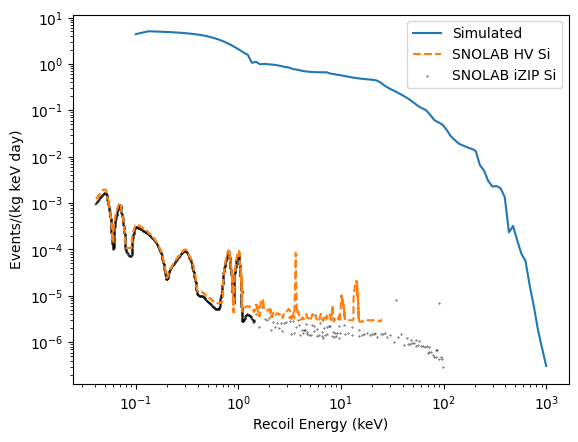

In [4]:
#Plot the data calculated above
#although these aren't entirely related
plt.plot(Er*1000,drde_Si,label='Simulated')
plt.plot(f6TR_nu[0],f6TR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7TR_nu[0],f7TR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")

plt.legend()
plt.show()

Compare shapes by re-scaling:

In [5]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0,myList[0]
    if pos == len(myList):
        return pos,myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos,after
    else:
        return pos,before

5.2789118728349384e-06


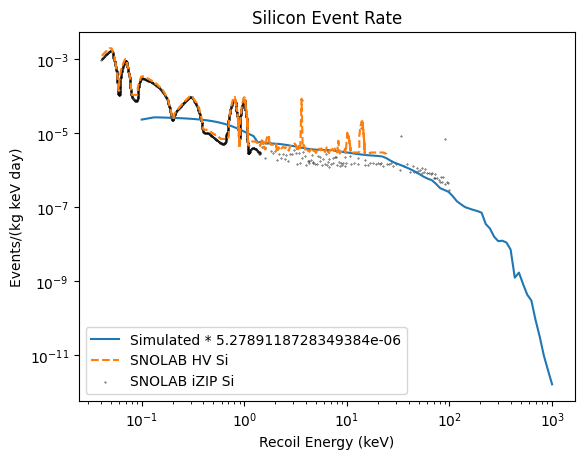

In [6]:
#finding values at 1keV

###Attempt at finding more robustly -- not working ###
#lorange = abs(f7TR_nu[0] - 2) < 0.5
#lo = median(f7TR_nu[1][lorange])/365
#closest = take_closest(list(f7TR_nu[1][lorange]),lo*365)
#print(closest)
#hi = drde_Si[
#    np.where(Er == take_closest(
#            Er,f7TR_nu[0][closest[0]])[1]
#    )
#]

###Simple by-eye version -- working ###
closest = take_closest(f6TR_nu[0],2)
lo = f6TR_nu[1][closest[0]]/365
hi = drde_Si[take_closest(Er*1000,2)[0]]

scale = lo/hi
print(scale)

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale,label='Simulated * '+str(scale))
plt.plot(f6TR_nu[0],f6TR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7TR_nu[0],f7TR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Silicon Event Rate")

plt.legend()
plt.show()

Mention in paper: restrict to region 1-100keV

# Ge Flux and Rate Generation

See 1-.../pyteomics_test.ipynb > cell 22

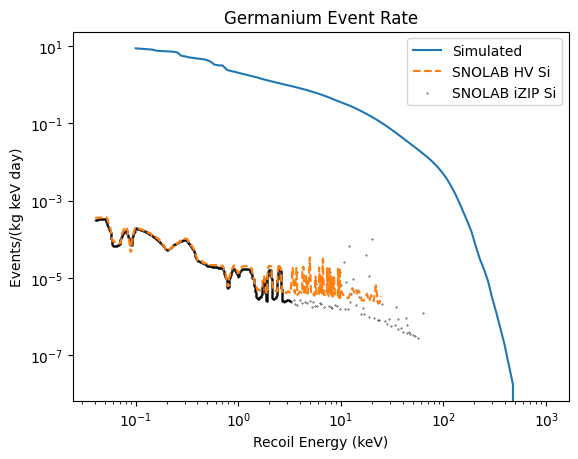

In [7]:
#Plot the data calculated above
#although these aren't entirely related
plt.plot(Er*1000,drde_Ge,label='Simulated')
plt.plot(f6BR_nu[0],f6BR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7BR_nu[0],f7BR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Germanium Event Rate")

plt.legend()
plt.show()

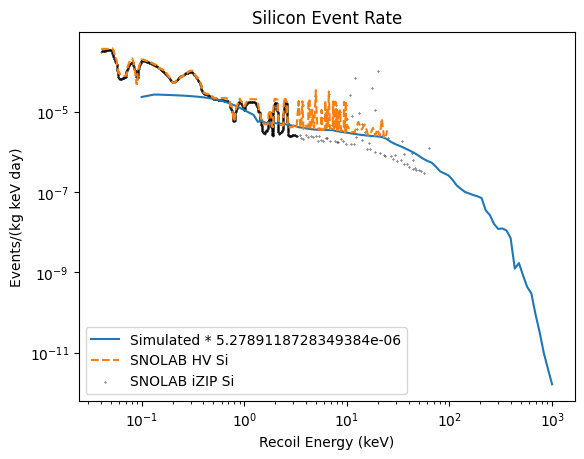

In [8]:
#finding values at 1keV

closest = take_closest(f6BR_nu[0],2)
lo = f6BR_nu[1][closest[0]]/365
hi = drde_Si[take_closest(Er*1000,2)[0]]

#Plot the data calculated above
plt.plot(Er*1000,drde_Si*scale,label='Simulated * '+str(scale))
plt.plot(f6BR_nu[0],f6BR_nu[1]/365,label='SNOLAB HV Si',linestyle='--')
plt.scatter(f7BR_nu[0],f7BR_nu[1]/365,label='SNOLAB iZIP Si',color='k',s=0.1)

plt.loglog()
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Events/(kg keV day)")
plt.title("Silicon Event Rate")

plt.legend()
plt.show()

# Flux Extraction

# Flux Comparisons

# Save
In case I need them again. Otherwise I'll delete them after I'm done with the other plots.